**Version using both datasets (random from Spotify + very popular musics (it has 190 popularity > 80 records) + SMOTE)**

In [ ]:
# Import Libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import KMeansSMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Dataset1: contains records fromm Spotify (used API) related to very popular musics (it has 190 popularity > 80 records)
# Dataset2: contains a random extract from Spofity
# Intention: merge the 2 datasets to have more Class 1 records
Dataset1 = pd.read_csv('clean_artists_df.csv')
Dataset2 = pd.read_csv('api_df.csv')

In [ ]:
# Remove unnecessary columns, rename columns, re-order columns for concatenation
Dataset1['Virality'] = (Dataset1['Popularity'] > 80).astype(int)
Dataset1.drop(['Unnamed: 0', 'Artist', 'Name', 'Album', 'Release Date', 'Popularity'], axis=1, inplace=True)
Dataset1.rename(columns={'Duration (s)': 'duration_s', 'Explicit': 'explicit', 'Danceability': 'danceability',
                         'Energy': 'energy', 'Key': 'key', 'Mode': 'mode', 'Valence': 'valence', 'Tempo':'tempo',
                         'Loudness':'loudness','Liveness': 'liveness', 'Instrumentalness': 'instrumentalness',
                         'Acousticness': 'acousticness', 'Virality': 'virality'}, inplace=True)
Dataset1 = Dataset1[['danceability','energy','key','loudness','mode','acousticness','instrumentalness','liveness','valence','tempo','duration_s','explicit','virality']]
Dataset1_final = Dataset1[Dataset1['virality']==1]
print('Class 1: ',len(Dataset1[Dataset1['virality']==1]))
print('Total: ', len(Dataset1_final))

Class 1:  190
Total:  190


In [ ]:
# Place virality columns (popularity > 80), converted 'explicit' to number, convert duration to seconds, remove unnecessary columns, rename columns
Dataset2['virality'] = (Dataset2['popularity'] > 80).astype(int)
Dataset2['explicit'] = Dataset2['explicit'].astype(int)
Dataset2['duration_ms'] = Dataset2['duration_ms'] / 1000
Dataset2.rename(columns={'duration_ms': 'duration_s'}, inplace=True)
Dataset2_final = Dataset2.drop(['Unnamed: 0', 'release_date', 'popularity','time_signature','speechiness'], axis=1)
print('Class 0: ', len(Dataset2[Dataset2['virality']==0]))
print('Class 1: ', len(Dataset2[Dataset2['virality']==1]))
print('Total: ', len(Dataset2_final))

Class 0:  2190
Class 1:  114
Total:  2304


In [ ]:
# Concat the two Datasets
Dataset_Concat = pd.concat([Dataset1_final, Dataset2_final], ignore_index=True)
print('Class 0: ', len(Dataset_Concat[Dataset_Concat['virality']==0]))
print('Class 1: ', len(Dataset_Concat[Dataset_Concat['virality']==1]))
print('Total: ', len(Dataset_Concat))
print('Number of NaN: ', np.sum(Dataset_Concat.isnull().sum()))

Class 0:  2190
Class 1:  304
Total:  2494
Number of NaN:  0


In [ ]:
Dataset_Concat.to_csv('Dataset_Concat_not_Normalized.csv')

In [ ]:
# Normalize numerical variables
numerical_features = ['danceability', 'energy', 'loudness', 'acousticness','instrumentalness', 'liveness', 'valence', 'tempo', 'duration_s']
scaler = StandardScaler()
Dataset_Concat[numerical_features] = scaler.fit_transform(Dataset_Concat[numerical_features])
Dataset_Concat.head(2)

,danceability,energy,key,loudness,mode,acousticness,instrumentalness,liveness,valence,tempo,duration_s,explicit,virality
0,-0.600132,-1.034705,11,-0.989867,1,0.468141,-0.224176,-0.620761,-0.971326,2.344060,0.016771,0,1
1,0.059866,-0.829851,0,-0.222401,1,-1.032637,-0.224301,-0.434852,-0.924486,-0.395964,0.829119,1,1


In [ ]:
Dataset_Concat.to_csv('Dataset_Concat_Normalized.csv')

In [ ]:
# Create X (independent variables), y (depedent variable = 'Virality') and Divide X and y in Training and Test Sets
# Used stratification to ensure both training set and test set have class 1 (viral track) samples
X = Dataset_Concat[['danceability', 'energy', 'key', 'loudness', 'mode', 'acousticness','instrumentalness', 'liveness', 'valence', 'tempo', 'duration_s','explicit']]
y = Dataset_Concat['virality']
#X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=7, test_size=0.20, stratify=y)

X_train_original, X_test, y_train_original, y_test = train_test_split(X,y,random_state=7, test_size=0.20, stratify=y)

# Using SMOTE(Synthetic Minority Oversampling Technique) as we have imabalanced Classes
smote = SVMSMOTE(random_state=7)
X_train, y_train = smote.fit_resample(X_train_original, y_train_original)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3504, 12)
(3504,)
(499, 12)
(499,)


In [ ]:
# Create Dataset to store fit results
df_fit_results = pd.DataFrame(columns=['Estimator', 'Grid', 'Score Type', 'Mean Cross-Validated Score', 'Std Dev Cross-Validated Score', 'Best Grid'])

In [ ]:
# Create Function to execute Grid Search to find the best combination of parameters for the classifier
# The function iterates to fast the best set of parameters for each type of score (accuracy, F1, ROC-AUC)
def fit_classifier(X_train,y_train, estimator, param_grid, cv, scores):
  global df_fit_results
  for the_score in scores:
    the_classifier = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cv, scoring=the_score)
    the_classifier.fit(X_train,y_train)

    df_result = pd.DataFrame({'Estimator': [estimator], 'Grid': [param_grid],'Score Type': [the_score],'Mean Cross-Validated Score': [the_classifier.best_score_],
                              'Std Dev Cross-Validated Score': [the_classifier.cv_results_['std_test_score'][the_classifier.best_index_]], 'Best Grid': [the_classifier.best_params_,]})

    df_fit_results = pd.concat([df_fit_results,df_result],ignore_index=True)
    print('Score for {}: {}'.format(the_score,np.around(the_classifier.best_score_,3)))
  print("Complete!")

In [ ]:
# Grid Search for Logistic Regression
estimator=LogisticRegression(random_state=7,solver='saga',class_weight='balanced')
param_grid = {"C":[0.001, 0.01, 0.1, 1.0, 10], "penalty":[None,"l1","l2","elasticnet"]}
cv=5
scores = ['accuracy', 'f1', 'roc_auc']
fit_classifier(X_train,y_train, estimator, param_grid, cv, scores)

Score for accuracy: 0.734
Score for f1: 0.716
Score for roc_auc: 0.83
Complete!


In [ ]:
# Grid Search for KNN
estimator=KNeighborsClassifier()
param_grid = {'n_neighbors': range(1,20,1), 'weights': ['uniform', 'distance'], 'leaf_size': [1, 5, 10], 'p': [1,2]}
cv=5
scores = ['accuracy', 'f1', 'roc_auc']
fit_classifier(X_train,y_train, estimator, param_grid, cv, scores)

Score for accuracy: 0.928
Score for f1: 0.929
Score for roc_auc: 0.972
Complete!


In [ ]:
# Grid Search for SVC
estimator=SVC(random_state=7, class_weight='balanced')
param_grid = param_grid = {'C': [0.1, 1, 10],  'gamma': ['scale', 'auto'], 'kernel': ['rbf']}
cv=5
scores = ['accuracy', 'f1', 'roc_auc']
fit_classifier(X_train,y_train, estimator, param_grid, cv, scores)

Score for accuracy: 0.922
Score for f1: 0.923
Score for roc_auc: 0.973
Complete!


In [ ]:
# Grid Search for RandomForest
estimator=RandomForestClassifier(random_state=7,class_weight='balanced')
param_grid = {'n_estimators':range(10,50,10), 'max_depth':[3,5,None],'min_samples_split':[1,2,3], 'min_samples_leaf':[1,2,3],'max_features':["sqrt", "log2", None]}
cv=5
scores = ['accuracy', 'f1', 'roc_auc']
fit_classifier(X_train,y_train, estimator, param_grid, cv, scores)

Score for accuracy: 0.94
Score for f1: 0.939
Score for roc_auc: 0.986
Complete!


In [ ]:
# Review Results
df_fit_results

,Estimator,Grid,Score Type,Mean Cross-Validated Score,Std Dev Cross-Validated Score,Best Grid
0,"LogisticRegression(class_weight='balanced', ra...","{'C': [0.001, 0.01, 0.1, 1.0, 10], 'penalty': ...",accuracy,0.733768,0.068428,"{'C': 1.0, 'penalty': 'l2'}"
1,"LogisticRegression(class_weight='balanced', ra...","{'C': [0.001, 0.01, 0.1, 1.0, 10], 'penalty': ...",f1,0.715895,0.091867,"{'C': 0.1, 'penalty': 'l2'}"
2,"LogisticRegression(class_weight='balanced', ra...","{'C': [0.001, 0.01, 0.1, 1.0, 10], 'penalty': ...",roc_auc,0.830457,0.085163,"{'C': 10, 'penalty': 'l2'}"
3,KNeighborsClassifier(),"{'n_neighbors': (1, 2, 3, 4, 5, 6, 7, 8, 9, 10...",accuracy,0.927802,0.022536,"{'leaf_size': 5, 'n_neighbors': 2, 'p': 1, 'we..."
4,KNeighborsClassifier(),"{'n_neighbors': (1, 2, 3, 4, 5, 6, 7, 8, 9, 10...",f1,0.929393,0.023834,"{'leaf_size': 5, 'n_neighbors': 2, 'p': 1, 'we..."
5,KNeighborsClassifier(),"{'n_neighbors': (1, 2, 3, 4, 5, 6, 7, 8, 9, 10...",roc_auc,0.972163,0.018768,"{'leaf_size': 10, 'n_neighbors': 15, 'p': 1, '..."
6,"SVC(class_weight='balanced', random_state=7)","{'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']...",accuracy,0.921525,0.019520,"{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}"
7,"SVC(class_weight='balanced', random_state=7)","{'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']...",f1,0.923077,0.021555,"{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}"
8,"SVC(class_weight='balanced', random_state=7)","{'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']...",roc_auc,0.972990,0.016639,"{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}"
9,RandomForestClassifier(class_weight='balanced'...,"{'n_estimators': (10, 20, 30, 40), 'max_depth'...",accuracy,0.940362,0.029811,"{'max_depth': None, 'max_features': 'sqrt', 'm..."


In [ ]:
# Print Grids for the best Classifier
for i in range(len(df_fit_results)):
  print(df_fit_results.iloc[i]['Best Grid'])

{'C': 1.0, 'penalty': 'l2'}
{'C': 0.1, 'penalty': 'l2'}
{'C': 10, 'penalty': 'l2'}
{'leaf_size': 5, 'n_neighbors': 2, 'p': 1, 'weights': 'uniform'}
{'leaf_size': 5, 'n_neighbors': 2, 'p': 1, 'weights': 'uniform'}
{'leaf_size': 10, 'n_neighbors': 15, 'p': 1, 'weights': 'distance'}
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 40}
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 40}
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 40}


In [ ]:
# Review Scores for Best Classifier, Option # 1
# {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 40}

best_classifier_option1 = RandomForestClassifier(random_state=7,
                                                 class_weight='balanced',
                                                 max_depth=None,
                                                 max_features='sqrt',
                                                 min_samples_leaf=1,
                                                 min_samples_split=3,
                                                 n_estimators= 40)
best_classifier_option1.fit(X_train,y_train)

y_pred_train = best_classifier_option1.predict(X_train)
y_pred_test = best_classifier_option1.predict(X_test)

print('F1 Score (Training): ', np.around(f1_score(y_train, y_pred_train),3))
print('F1 Score (Test): ', np.around(f1_score(y_test, y_pred_test),3))

F1 Score (Training):  0.999
F1 Score (Test):  0.606


In [ ]:
# Review Scores for Best Classifier, Option # 2
# {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 40}

best_classifier_option2 = RandomForestClassifier(random_state=7,
                                                 class_weight='balanced',
                                                 max_depth=None,
                                                 max_features='sqrt',
                                                 min_samples_leaf=1,
                                                 min_samples_split=3,
                                                 n_estimators= 40)
best_classifier_option2.fit(X_train,y_train)

y_pred_train = best_classifier_option2.predict(X_train)
y_pred_test = best_classifier_option2.predict(X_test)

print('F1 Score (Training): ', np.around(f1_score(y_train, y_pred_train),3))
print('F1 Score (Test): ', np.around(f1_score(y_test, y_pred_test),3))

F1 Score (Training):  0.999
F1 Score (Test):  0.606


In [ ]:
# Review Scores for Best Classifier, Option # 3
# {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 40}

best_classifier_option3 = RandomForestClassifier(random_state=7,
                                                 class_weight='balanced',
                                                 max_depth=None,
                                                 max_features='sqrt',
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 n_estimators= 40)
best_classifier_option3.fit(X_train,y_train)

y_pred_train = best_classifier_option3.predict(X_train)
y_pred_test = best_classifier_option3.predict(X_test)

print('F1 Score (Training): ', np.around(f1_score(y_train, y_pred_train),3))
print('F1 Score (Test): ', np.around(f1_score(y_test, y_pred_test),3))

F1 Score (Training):  0.999
F1 Score (Test):  0.636


In [ ]:
# Prepare the best classifier to be used for further evaluations
# {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 40}
best_classifier = RandomForestClassifier(random_state=7,
                                                 class_weight='balanced',
                                                 max_depth=None,
                                                 max_features='sqrt',
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 n_estimators= 40)
best_classifier.fit(X_train,y_train)
y_pred_test = best_classifier.predict(X_test)

print('F1: ', np.around(f1_score(y_test, y_pred_test),3))
print('Accuracy: ', np.around(accuracy_score(y_test, y_pred_test),3))
print('ROC-AUC: ', np.around(roc_auc_score(y_test, y_pred_test),3))
print('Precision: ', np.around(precision_score(y_test, y_pred_test),3))
print('Recall: ', np.around(recall_score(y_test, y_pred_test),3))

F1:  0.636
Accuracy:  0.922
ROC-AUC:  0.765
Precision:  0.739
Recall:  0.557


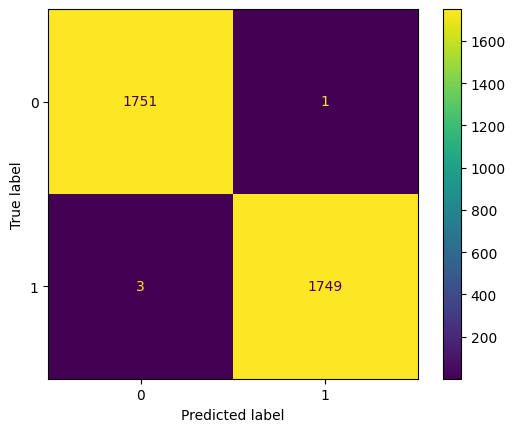

In [ ]:
ConfusionMatrixDisplay.from_estimator(best_classifier, X_train, y_train)

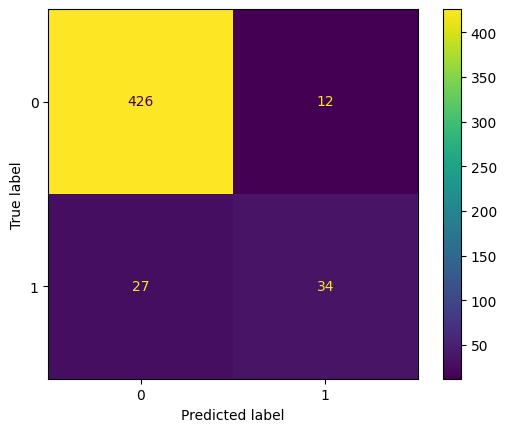

In [ ]:
ConfusionMatrixDisplay.from_estimator(best_classifier, X_test, y_test)

In [ ]:
# For the following parts of the evaluation, typically you will do these deeper analysis steps only on your best-performing model (not all of them)
# Do a feature importance and/or ablation analysis on your best model to get insight into which features are or are not contributing to prediction
# success/failure.

In [ ]:
# Get Feature Importance from the Best Classifier, place them in order of importance and calculate the cumulative
the_variables = ['danceability', 'energy', 'key', 'loudness', 'mode', 'acousticness','instrumentalness', 'liveness', 'valence', 'tempo', 'duration_s','explicit']
the_importance = sorted(list(zip(the_variables, best_classifier.feature_importances_)),key=lambda x:x[1], reverse=True)
the_importance_in_order = [feature for feature,score in the_importance]
the_scores_in_order = [score for feature,score in the_importance]
the_scores_in_order_cumsum = np.cumsum(the_scores_in_order)

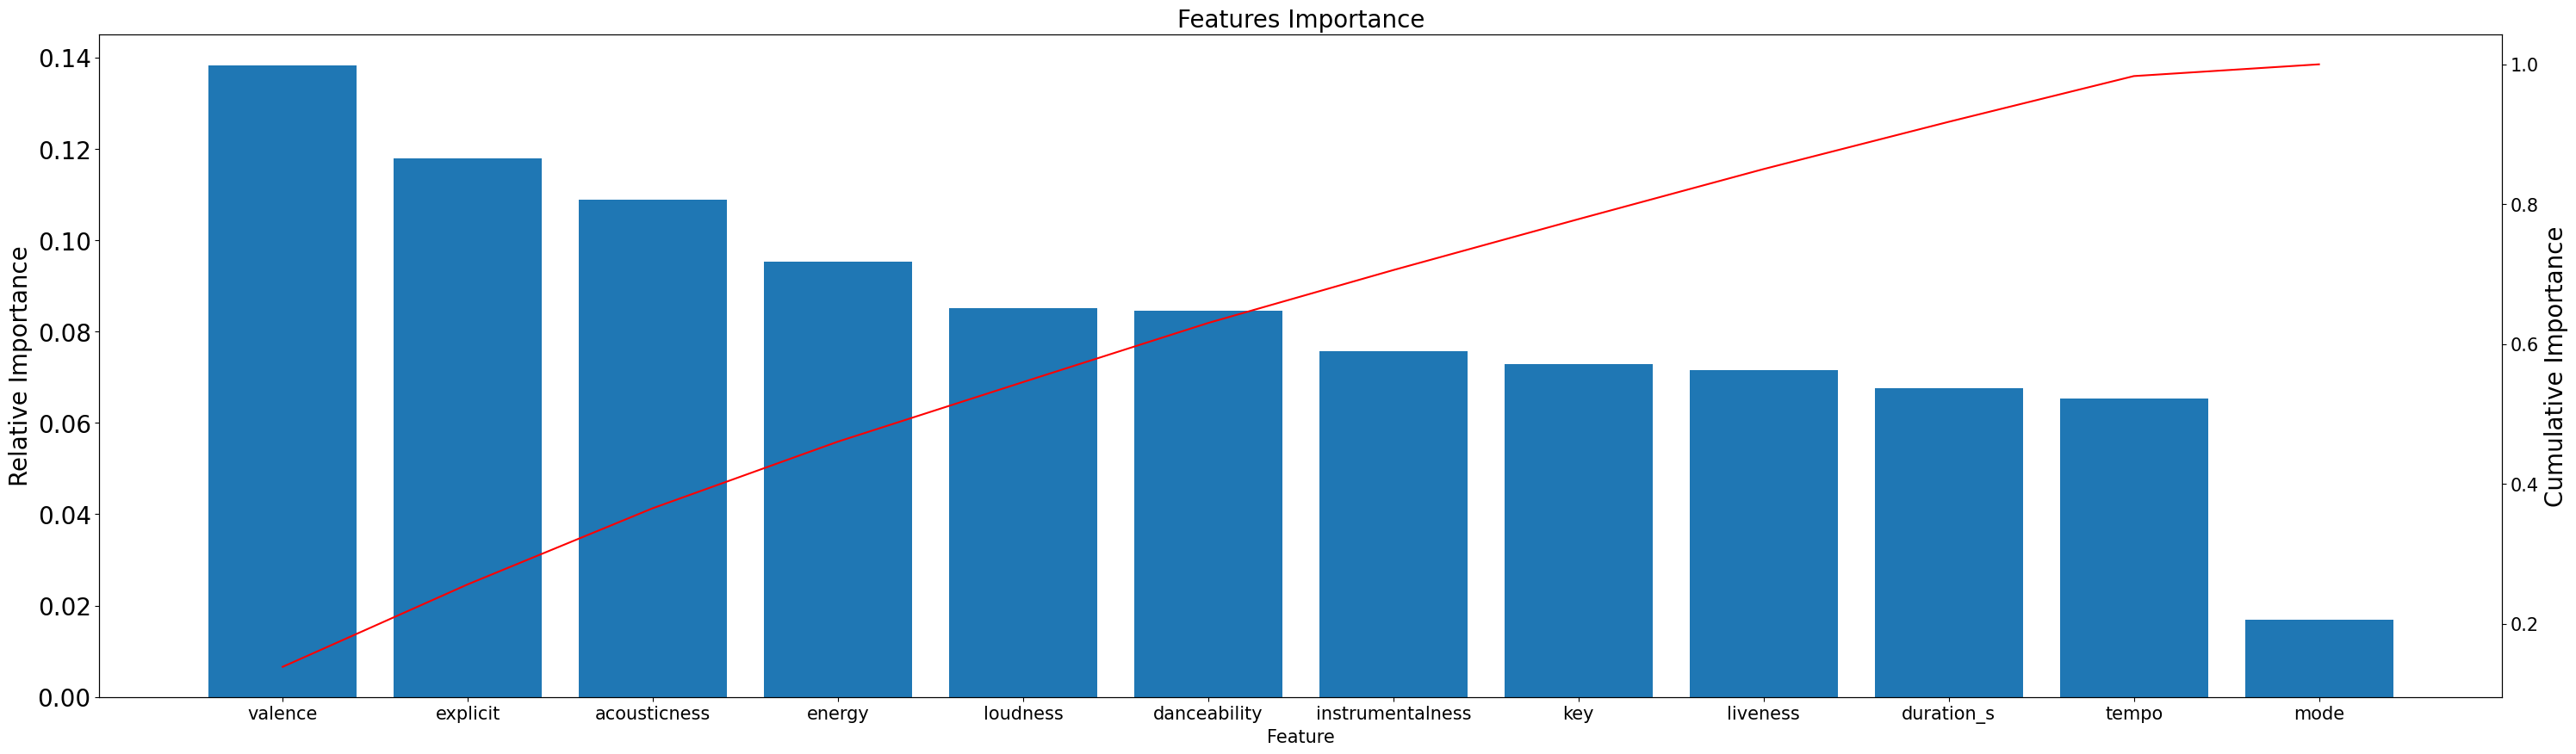

In [ ]:
# Plot Importance
fig, ax1 = plt.subplots(figsize=(36, 10))

ax1.set_xlabel('Feature',fontsize=15)
ax1.set_ylabel('Relative Importance',fontsize=20)
ax1.bar(the_importance_in_order, the_scores_in_order)
ax1.tick_params(axis='y')
plt.xticks(fontsize=15)
plt.yticks(fontsize=20)

ax2 = ax1.twinx()
ax2.set_ylabel('Cumulative Importance',fontsize=20)
ax2.plot(the_importance_in_order, the_scores_in_order_cumsum, color='red')
ax2.tick_params(axis='y')

plt.yticks(fontsize=15)
plt.title("Features Importance",fontsize=20)
plt.show()

In [ ]:
# Do at least one sensitivity analysis on your best model: How sensitive are your results to choice of (hyper-)parameters, features,
# or other varying solution elements?

In [ ]:
# Use Grid Search to calculate the change in F1 score based on the size of the tree ("sensitivity analysis")
sensitivity_estimator = RandomForestClassifier(random_state=7,
                                                 class_weight='balanced',
                                                 max_depth=None,
                                                 max_features='sqrt',
                                                 min_samples_leaf=1,
                                                 min_samples_split=2)
param_grid = {'n_estimators':range(1,100,2)}
the_classifier = GridSearchCV(estimator=sensitivity_estimator, param_grid=param_grid, cv=5, scoring='f1')
the_classifier.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=7),
             param_grid={'n_estimators': range(1, 100, 2)}, scoring='f1')

([<matplotlib.axis.XTick at 0x7b4fddd0fa90>,
 [Text(0, 0, '0'),
  Text(5, 0, '5'),
  Text(10, 0, '10'),
  Text(15, 0, '15'),
  Text(20, 0, '20'),
  Text(25, 0, '25'),
  Text(30, 0, '30'),
  Text(35, 0, '35'),
  Text(40, 0, '40'),
  Text(45, 0, '45'),
  Text(50, 0, '50'),
  Text(55, 0, '55'),
  Text(60, 0, '60'),
  Text(65, 0, '65'),
  Text(70, 0, '70'),
  Text(75, 0, '75'),
  Text(80, 0, '80'),
  Text(85, 0, '85'),
  Text(90, 0, '90'),
  Text(95, 0, '95')])

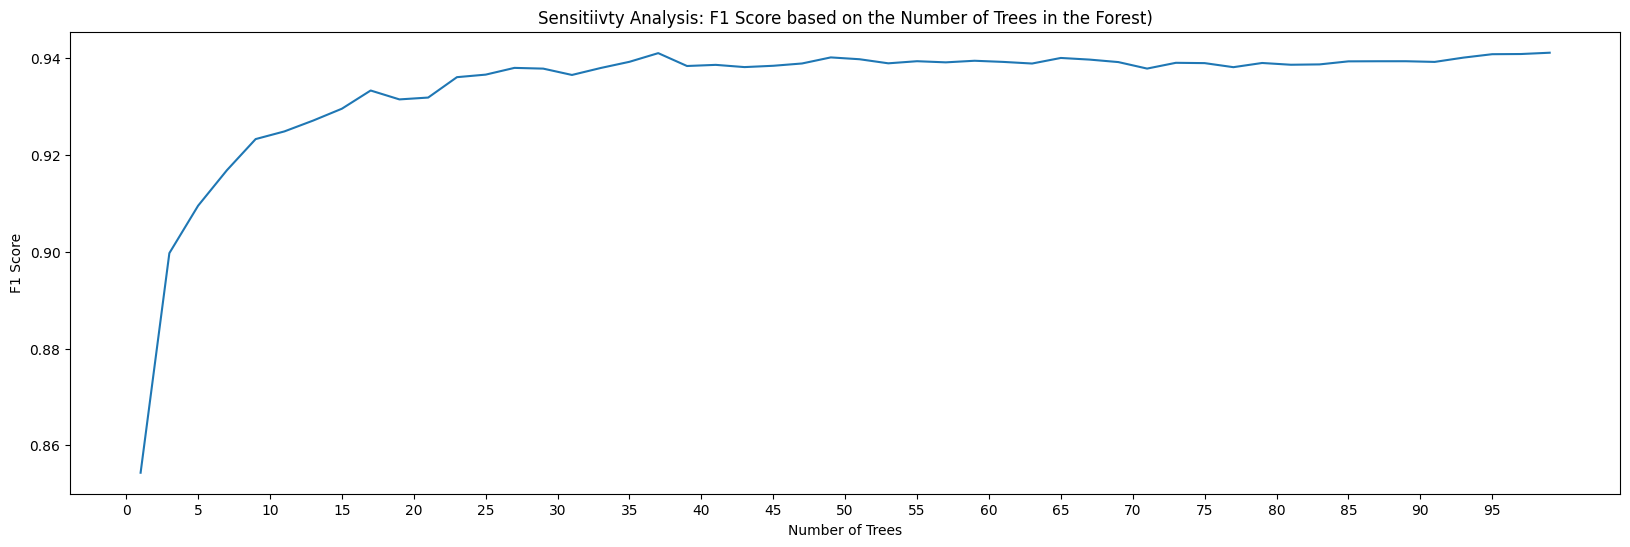

In [ ]:
# Plot Sensitivity Analysis (F1 Score x Number of Trees)
sens_plot_x = range(1,100,2)
sens_plot_y = the_classifier.cv_results_['mean_test_score']
plt.figure(figsize=(20, 6))
plt.plot(sens_plot_x, sens_plot_y)
plt.xlabel('Number of Trees')
plt.ylabel('F1 Score')
plt.title("Sensitiivty Analysis: F1 Score based on the Number of Trees in the Forest)")
plt.xticks(range(0,100,5))

In [ ]:
# Trade Off Analysis

In [ ]:
# Calculate Precision and Recall based on Threshold
precisions = []
recalls = []
f1s = []
ROC_AUCs = []
thresholds = np.linspace(0.1, 1.0, num=50)
for threshold in thresholds:
  y_probs_test = best_classifier.predict_proba(X_test)
  y_pred_test = (y_probs_test[:, 1] > threshold).astype(int)
  the_precision = precision_score(y_test, y_pred_test)
  the_recall = recall_score(y_test, y_pred_test)
  the_f1 = f1_score(y_test, y_pred_test)
  the_ROC_AUC = roc_auc_score(y_test, y_pred_test)
  precisions.append(the_precision)
  recalls.append(the_recall)
  f1s.append(the_f1)
  ROC_AUCs.append(the_ROC_AUC)

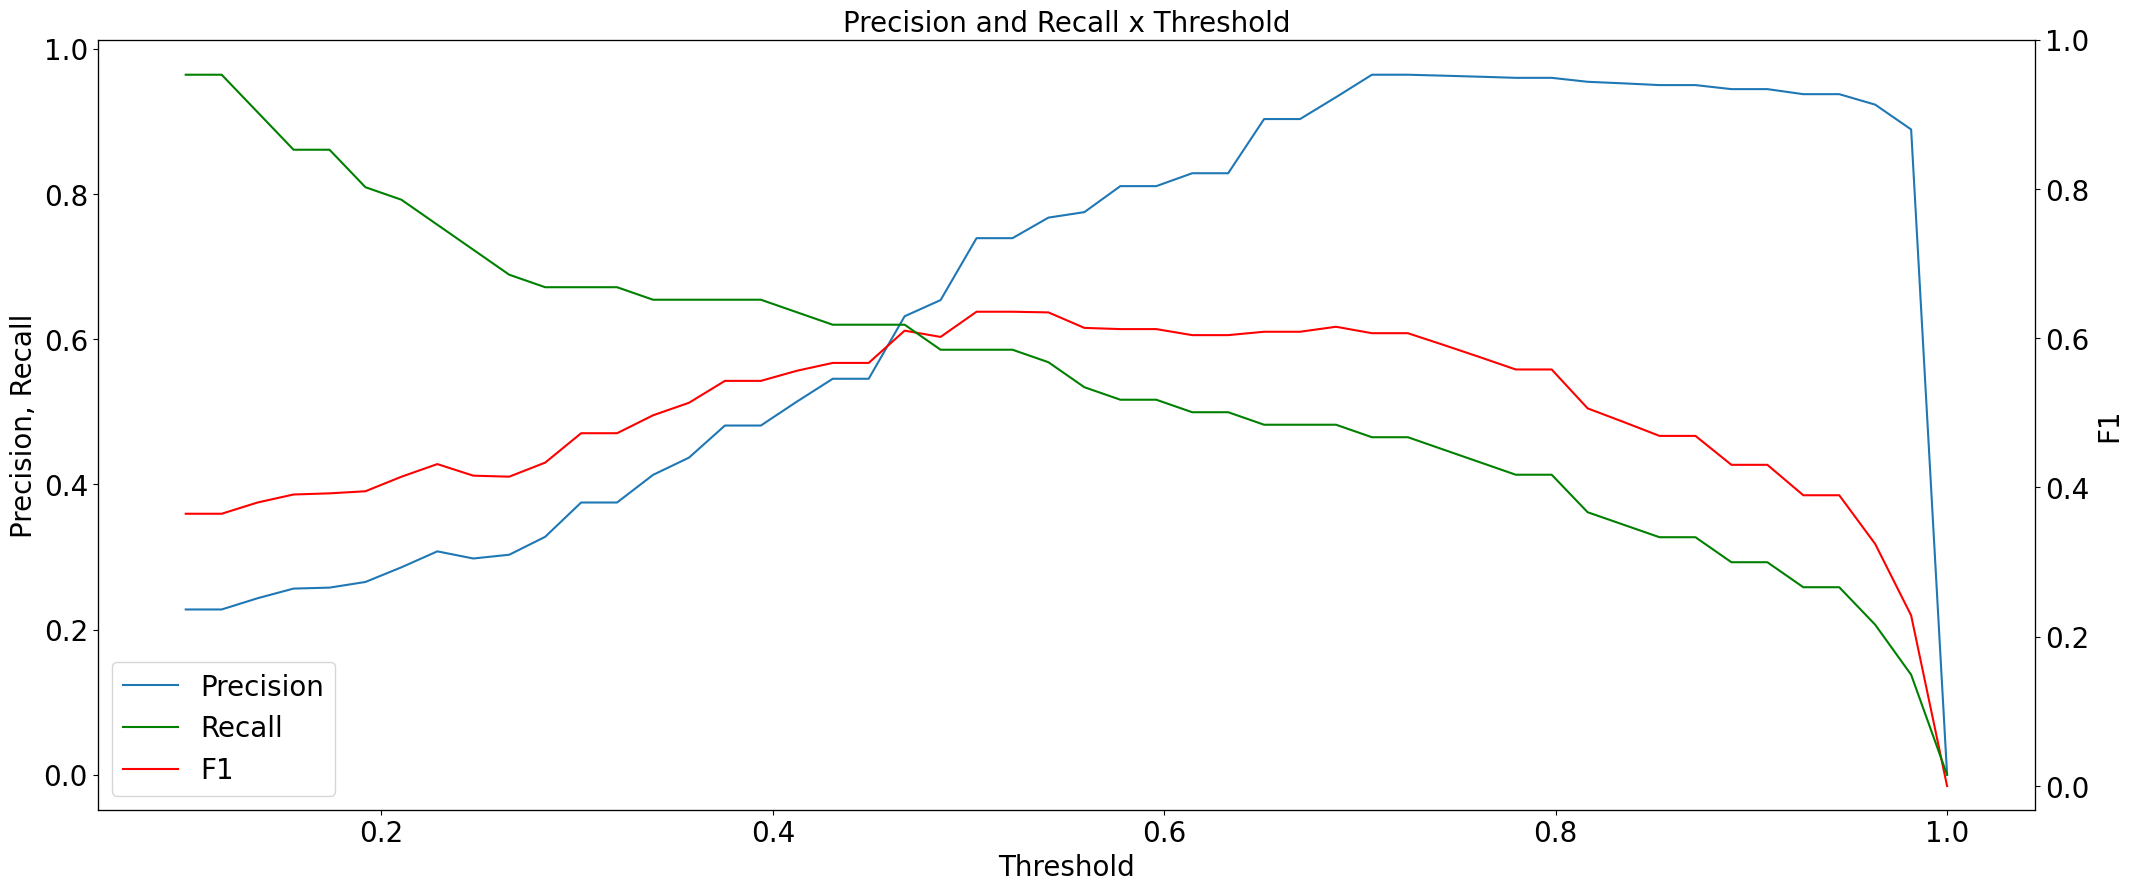

In [ ]:
# Plot Precision and Recall x Threshold

fig, ax1 = plt.subplots(figsize=(25, 10))

ax1.set_xlabel('Threshold',fontsize=20)
ax1.set_ylabel('Precision, Recall',fontsize=20)
ax1.plot(thresholds, precisions, label='Precision')
ax1.tick_params(axis='y')
plt.xticks(fontsize=20)
plt.yticks(ticks=[0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=20)

ax2 = ax1.twinx()
ax2.set_ylabel('F1',fontsize=20)
ax2.plot(thresholds, f1s, color='red',label='F1')
ax2.tick_params(axis='y')
plt.yticks(ticks=[0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=20)

ax3 = ax1.twinx()
ax3.plot(thresholds, recalls, color='green', label='Recall')
ax3.get_yaxis().set_ticks([])

plt.title("Precision and Recall x Threshold",fontsize=20)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax1.legend(lines1 + lines3 + lines2, labels1 + labels3 + labels2, fontsize=20, loc='lower left')

plt.show()

In [ ]:
df_precision_recall = pd.DataFrame(data=np.column_stack([thresholds, precisions, recalls, f1s]), columns=['thresholds', 'precisions', 'recalls', 'f1s'])
df_precision_recall

,thresholds,precisions,recalls,f1s
0,0.100000,0.227642,0.918033,0.364821
1,0.118367,0.227642,0.918033,0.364821
2,0.136735,0.243119,0.868852,0.379928
3,0.155102,0.256410,0.819672,0.390625
4,0.173469,0.257732,0.819672,0.392157
5,0.191837,0.265537,0.770492,0.394958
6,0.210204,0.285714,0.754098,0.414414
7,0.228571,0.307692,0.721311,0.431373
8,0.246939,0.297872,0.688525,0.415842
9,0.265306,0.303030,0.655738,0.414508


In [ ]:
threshold = 0.45
y_probs_test = best_classifier.predict_proba(X_test)
y_pred_test = (y_probs_test[:, 1] > threshold).astype(int)

print(precision_score(y_test, y_pred_test))
print(recall_score(y_test, y_pred_test))
print(f1_score(y_test, y_pred_test))
print(balanced_accuracy_score(y_test, y_pred_test))
print(roc_auc_score(y_test, y_pred_test))

0.631578947368421
0.5901639344262295
0.6101694915254237
0.7711093644733887
0.7711093644733887


In [ ]:
#Failure analysis
#Select at least 3 *specific* examples where prediction failed, and analyze possible reasons why.

In [ ]:
# Review the items which were predicted wrongly
df_wrong_classified = X_test.copy()
df_wrong_classified['y_true'] = y_test
df_wrong_classified['y_pred'] = best_classifier.predict(X_test)
df_wrong_classified['Pred_Proba_0'] = best_classifier.predict_proba(X_test)[:,0]
df_wrong_classified['Pred_Proba_1'] = best_classifier.predict_proba(X_test)[:,1]

In [ ]:
# Filter the Dataset to find the wrong classified
# Remember that the values below are normalized!!!
df_wrong_classified_filtered = df_wrong_classified[df_wrong_classified['y_true'] != df_wrong_classified['y_pred']]
df_wrong_classified_filtered

,danceability,energy,key,loudness,mode,acousticness,instrumentalness,liveness,valence,tempo,duration_s,explicit,y_true,y_pred,Pred_Proba_0,Pred_Proba_1
2056,-0.190933,0.574863,1,0.597440,1,-1.169550,-0.224301,1.082269,-0.251698,-1.374422,-0.255571,0,0,1,0.475000,0.525000
1086,0.475664,0.223684,11,0.130906,1,-1.141466,-0.224301,-0.478376,-0.319829,1.105293,0.521004,1,0,1,0.325000,0.675000
2196,-0.210733,0.321234,9,0.806034,1,-0.084272,-0.224301,-0.690400,0.761742,1.503534,-0.627437,1,1,0,0.775000,0.225000
1631,1.089462,0.511455,5,0.694622,1,-0.851697,-0.224301,-0.650606,0.259280,-0.874014,0.053038,0,1,0,0.675000,0.325000
18,-1.603328,-0.581099,2,-0.374078,1,0.974244,-0.224301,-0.636927,-0.924486,1.673979,-0.554775,0,1,0,0.825000,0.175000
189,-1.557128,0.062728,6,0.009201,0,-0.510987,-0.013528,-0.659933,-0.345378,-0.972795,0.369216,0,1,0,0.875000,0.125000
1958,-1.616528,-0.634752,6,-0.666835,0,0.279593,0.055632,-0.721488,-1.969011,-1.701435,0.974658,0,0,1,0.450000,0.550000
129,0.997062,-0.366490,2,1.005847,1,0.669921,-0.224301,-0.782422,1.753891,-1.075028,-0.888408,0,1,0,0.825000,0.175000
2094,0.013666,-0.722546,8,0.317398,1,-0.454753,-0.224301,1.156882,0.118761,1.900300,0.010648,0,1,0,0.850000,0.150000
2469,1.195061,1.023591,11,0.970426,1,-1.094164,-0.223256,-0.577859,-0.064340,0.064221,-0.551910,0,1,0,0.525000,0.475000


In [ ]:
df_wrong_classified_filtered[ (df_wrong_classified_filtered['y_true'] ==0) & (df_wrong_classified_filtered['y_pred'] ==1)]

,danceability,energy,key,loudness,mode,acousticness,instrumentalness,liveness,valence,tempo,duration_s,explicit,y_true,y_pred,Pred_Proba_0,Pred_Proba_1
2056,-0.190933,0.574863,1,0.597440,1,-1.169550,-0.224301,1.082269,-0.251698,-1.374422,-0.255571,0,0,1,0.475,0.525
1086,0.475664,0.223684,11,0.130906,1,-1.141466,-0.224301,-0.478376,-0.319829,1.105293,0.521004,1,0,1,0.325,0.675
1958,-1.616528,-0.634752,6,-0.666835,0,0.279593,0.055632,-0.721488,-1.969011,-1.701435,0.974658,0,0,1,0.450,0.550
1567,0.667063,0.516333,1,-0.051349,1,-0.639994,-0.224301,-0.254538,-0.353894,0.097204,-0.565905,0,0,1,0.425,0.575
2472,1.122461,-0.366490,2,1.021287,1,-0.583760,-0.224008,-0.397545,-0.490155,-0.572643,-0.131025,0,0,1,0.350,0.650
2163,1.544860,0.272459,5,0.437892,0,-0.880806,-0.224260,0.025259,-0.741386,-0.806473,-0.526329,0,0,1,0.425,0.575
457,1.234661,0.487068,1,0.515698,0,-0.527526,-0.224227,-0.646254,0.276313,-1.410287,-0.622949,0,0,1,0.350,0.650
1591,0.112665,-0.088474,0,-0.262061,0,0.544222,-0.220893,0.398321,0.105986,0.267246,0.151078,0,0,1,0.000,1.000
1159,-0.144734,0.306601,9,0.269564,0,-0.140506,-0.224301,1.896789,-0.524220,-1.610899,-1.035620,1,0,1,0.460,0.540
1230,0.950862,0.726064,9,0.967701,0,-0.441522,-0.224301,-0.534335,-0.651965,0.456228,-0.216198,1,0,1,0.300,0.700


In [ ]:
df_wrong_classified_filtered[ (df_wrong_classified_filtered['y_true'] ==1) & (df_wrong_classified_filtered['y_pred'] ==0)]

,danceability,energy,key,loudness,mode,acousticness,instrumentalness,liveness,valence,tempo,duration_s,explicit,y_true,y_pred,Pred_Proba_0,Pred_Proba_1
2196,-0.210733,0.321234,9,0.806034,1,-0.084272,-0.224301,-0.690400,0.761742,1.503534,-0.627437,1,1,0,0.775000,0.225000
1631,1.089462,0.511455,5,0.694622,1,-0.851697,-0.224301,-0.650606,0.259280,-0.874014,0.053038,0,1,0,0.675000,0.325000
18,-1.603328,-0.581099,2,-0.374078,1,0.974244,-0.224301,-0.636927,-0.924486,1.673979,-0.554775,0,1,0,0.825000,0.175000
189,-1.557128,0.062728,6,0.009201,0,-0.510987,-0.013528,-0.659933,-0.345378,-0.972795,0.369216,0,1,0,0.875000,0.125000
129,0.997062,-0.366490,2,1.005847,1,0.669921,-0.224301,-0.782422,1.753891,-1.075028,-0.888408,0,1,0,0.825000,0.175000
2094,0.013666,-0.722546,8,0.317398,1,-0.454753,-0.224301,1.156882,0.118761,1.900300,0.010648,0,1,0,0.850000,0.150000
2469,1.195061,1.023591,11,0.970426,1,-1.094164,-0.223256,-0.577859,-0.064340,0.064221,-0.551910,0,1,0,0.525000,0.475000
134,1.056462,-0.371368,2,1.010691,1,0.570685,-0.224301,-0.792370,1.770924,-1.076369,-0.888395,0,1,0,0.825000,0.175000
1702,1.036662,-0.454285,9,0.025852,1,0.577301,-0.224280,-0.571641,-0.383701,-1.008996,-0.382907,0,1,0,0.525000,0.475000
19,-0.520932,-0.717669,0,-0.256006,1,1.387727,-0.224301,-0.565424,-1.239589,-1.736496,-0.182048,0,1,0,0.850000,0.150000


In [ ]:
FN_list = df_wrong_classified_filtered[ (df_wrong_classified_filtered['y_true'] ==1) & (df_wrong_classified_filtered['y_pred'] ==0)].index.tolist()

In [ ]:
len(FN_list)

27

In [ ]:
Dataset_not_normalized = pd.read_csv('Dataset_Concat_not_Normalized.csv')

In [ ]:
Dataset_not_normalized.iloc[FN_list].describe()

,Unnamed: 0,danceability,energy,key,loudness,mode,acousticness,instrumentalness,liveness,valence,tempo,duration_s,explicit,virality
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.0
mean,955.629630,0.605667,0.554333,4.888889,-7.389333,0.777778,0.391817,0.021566,0.142089,0.480033,114.108333,225.496667,0.185185,1.0
std,924.452859,0.144141,0.193452,3.129676,3.048585,0.423659,0.299678,0.082382,0.086374,0.263274,28.969646,55.517678,0.395847,0.0
min,9.000000,0.294000,0.202000,0.000000,-15.159000,0.000000,0.007570,0.000000,0.050100,0.094900,70.266000,140.533000,0.000000,1.0
25%,114.000000,0.539500,0.402000,2.000000,-10.154000,1.000000,0.132500,0.000000,0.090550,0.238000,91.875500,183.991000,0.000000,1.0
50%,189.000000,0.609000,0.523000,6.000000,-7.409000,1.000000,0.328000,0.000000,0.104000,0.474000,107.747000,215.760000,0.000000,1.0
75%,1698.500000,0.739000,0.703500,7.000000,-4.858000,1.000000,0.594000,0.000295,0.176500,0.671000,129.009500,245.244000,0.000000,1.0
max,2469.000000,0.825000,0.882000,11.000000,-2.862000,1.000000,0.960000,0.414000,0.382000,0.931000,178.765000,351.640000,1.000000,1.0


In [ ]:
Dataset_not_normalized.iloc[FN_list]

,Unnamed: 0,danceability,energy,key,loudness,mode,acousticness,instrumentalness,liveness,valence,tempo,duration_s,explicit,virality
2196,2196,0.563,0.664,9,-5.044,1,0.33500,0.000000,0.0849,0.6880,166.928,178.146,1,1
1631,1631,0.760,0.703,5,-5.412,1,0.10300,0.000000,0.0913,0.5700,95.997,231.826,0,1
18,18,0.352,0.479,2,-8.942,1,0.65500,0.000000,0.0935,0.2920,172.013,183.878,0,1
189,189,0.359,0.611,6,-7.676,0,0.20600,0.025600,0.0898,0.4280,93.050,256.768,0,1
129,129,0.746,0.523,2,-4.384,1,0.56300,0.000000,0.0701,0.9210,90.000,157.559,0,1
2094,2094,0.597,0.450,8,-6.658,1,0.22300,0.000000,0.3820,0.5370,178.765,228.482,0,1
2469,2469,0.776,0.808,11,-4.501,1,0.02970,0.000127,0.1030,0.4940,123.988,184.104,0,1
134,134,0.755,0.522,2,-4.368,1,0.53300,0.000000,0.0685,0.9250,89.960,157.560,0,1
1702,1702,0.752,0.505,9,-7.621,1,0.53500,0.000003,0.1040,0.4190,91.970,197.436,0,1
19,19,0.516,0.451,0,-8.552,1,0.78000,0.000000,0.1050,0.2180,70.266,213.281,0,1


In [ ]:
# Build Dataset with Summary Statistics for each dependent variable
df_statistics = pd.DataFrame(columns=['Variable', 'Min', '-3 Std', 'Mean', '+3 Std', 'Max'])
the_variables = ['danceability', 'energy', 'loudness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','duration_s']

for the_variable in the_variables:
  the_mean = np.around(np.mean(Dataset_not_normalized[the_variable]),4)
  the_minus_3std = np.around(Dataset_not_normalized[the_variable].quantile(0.015),4)
  the_plus_3std = np.around(Dataset_not_normalized[the_variable].quantile(0.9985),4)
  the_min = np.around(np.min(Dataset_not_normalized[the_variable]),4)
  the_max = np.around(np.max(Dataset_not_normalized[the_variable]),4)

  df_statistics_partial = pd.DataFrame({'Variable':[the_variable], 'Min':[the_min], '-3 Std':[the_minus_3std], 'Mean':[the_mean], '+3 Std':[the_plus_3std], 'Max':[the_max]})
  df_statistics = pd.concat([df_statistics,df_statistics_partial], ignore_index=True)

df_statistics

,Variable,Min,-3 Std,Mean,+3 Std,Max
0,danceability,0.1230,0.2286,0.5949,0.9160,0.951
1,energy,0.0450,0.1480,0.5981,0.9860,0.997
2,loudness,-28.2700,-16.6950,-7.7064,-0.8918,0.214
3,acousticness,0.0000,0.0008,0.3605,0.9938,0.996
4,instrumentalness,0.0000,0.0000,0.0272,0.9450,0.956
5,liveness,0.0198,0.0501,0.1959,0.9730,0.984
6,valence,0.0327,0.0832,0.5091,0.9720,0.974
7,tempo,50.0110,74.5453,122.0721,203.8824,209.615
8,duration_s,34.2500,107.6310,227.6420,730.9092,1452.267
